# FGSM and BIM

Although adversarial attacks can be used in different domains, in these workshop we will apply them to images, generating adversarial images that have the potential to mislead image classifiers.

In this notebook we will be using the Adversarial Attacks *FGSM* (Fast Gradient Sign Method) introduced in the publication {cite}`goodfellow2015explaining`.

This method is considered a *White-Box Attack*, meaning that we need to 
have access to the machine learning model to be able to perform the attack.

We will be working with the open source machine learning framework PyTorch for Python.

In [1]:
import os
from typing import List
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import *
from PIL import Image

print(np.__version__)

np.random.seed(42)

# path to the data folder
data_folder = os.path.join('data')

1.24.4


Before we can use the model to make any predictions, we need to select the pytorch device that we are going to use. The current versions of PyTorch supports GPU acceleration. This support has a major impact of the time needed, not only for training deep learning models but also for using them to make predictions

Although the current version of PyTorch (1.9, as August 2021) supports CUDA (for Nvidia's GPUs) and ROCm (for AMD's GPUs), the latest is still in a beta state.

As the computers in the cloud GPU service(s) has CUDA enabled Nvidia GPUs, we will use cuda to accelerate the computation

In [3]:
# use compatible NVidia GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda found!')
else:
    device = torch.device('cpu')
    print('no cuda found, will use cpu')

no cuda found, will use cpu


## Loading the model

To be able to use this attack, first we need to select the machine learning model that we will use as an image classifier. For that purpose, we we will use the models available in the library torchvision, that is part of pytorch.

These models have been pre-trained in 1000 categories from the image dataset [ImageNet](https://image-net.org/).

We can find the models available on the [torchvision website](https://pytorch.org/vision/stable/index.html).

In [4]:
# we set the parameters pretrained and progress to True, to download the pretrained model with a progress bar
net = torchvision.models.alexnet(pretrained=True, progress=True)

# when we load a model with pytorch, by default it is in train mode
# as we are going to use the model to make predictions we set it with evaluation mode
# with the ; we hide the output that was going to be printed out 
net.eval(); 

If a GPU is available we first need to pass the model to it. If it is not available the line will not change anything as it is already attached to the memomry of the CPU.

In [5]:
# we pass the model to the device just with this one line of code
net.to(device);

We also need to load the labels associated to the categories used to train the model. In this case the categories are the 1000 used in the competition ImageNet Large Scale Visual Recognition Challenge. 

In the text file synset_words.txt you can see all the categories of images that the mode has been trained on. These categories, also known as <i>synsets</i>, were inheret from project [Wordnet](https://wordnet.princeton.edu/).

They use several keywords to describe each category. In the file synset_words.txt, I abbreviated these keywords. You can find the original list in this link: https://gist.github.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372

In [6]:
with open(os.path.join(data_folder, 'synset_words.txt'), 'r') as f:
    synset_words = [' '.join(s.replace('\n', '').split(' ')[1:]) for s in f.readlines()]

np.random.choice(synset_words, 5)

array(['echidna, spiny anteater, anteater',
       'bathtub, bathing tub, bath, tub',
       'tobacco shop, tobacconist shop, tobacconist',
       'white wolf, Arctic wolf, Canis lupus tundrarum', 'wombat'],
      dtype='<U121')

## Loading and visualizing images

We will load some images that we will use for our attacks with the library PIL.

In [7]:
images = {}
for file_name in glob.glob(os.path.join(data_folder, 'images', 'dataset', '*')):
    # remove file extension and path
    short_file_name = os.path.splitext(os.path.split(file_name)[-1])[0]
    images[os.path.splitext(short_file_name)[0]] = {
        # Image is from PIL library
        'image': Image.open(file_name)
    }
    print(f"loaded {file_name}")

loaded data/images/dataset/dog.jpg
loaded data/images/dataset/harmonicawood.jpg
loaded data/images/dataset/pineapple.jpg
loaded data/images/dataset/joys.jpg
loaded data/images/dataset/jellyfish.jpg
loaded data/images/dataset/teapot.jpg
loaded data/images/dataset/pizza.jpg
loaded data/images/dataset/bus.jpg
loaded data/images/dataset/pig.jpg
loaded data/images/dataset/bear.jpg


Once we load the image, we are going to conduct a pre-processing step.
This pre-processing is necessary as the network was trained with this pre-processing, so if we want to use the net we need to take those steps into account as well.

We will also write a reverse function `plot_alexnet_image` which allows us to show us the image that was used in the network.

In [8]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# classes are from torchvision.transform
preprocess_alexnet = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor(),
    Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

def plot_alexnet_image(img_tensor: torch.tensor) -> None:
    # alexnet has this strange permutation of 
    img_tensor = img_tensor.permute(1, 2, 0)
    img_np = img_tensor.detach().cpu().numpy()
    
    # _STD[None, None] adds 2 dimensions so we are multiplying the color dimension of the picture
    img_np = (img_np * IMAGENET_STD[None,None]) + IMAGENET_MEAN[None,None]
    img_np = np.clip(img_np, a_min=0.0, a_max=1.0)
    
    # we plot the image 
    plt.figure()
    plt.axis('off')
    plt.imshow(img_np)

Now we will choose a random image to start with.

Filename: bus


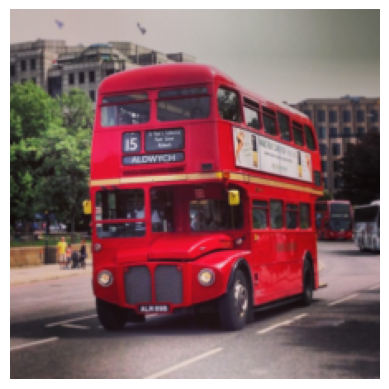

In [9]:
# select one random image image
random_file_name = np.random.choice(list(images.keys()))
random_image = images[random_file_name]['image']

original_img_tensor = preprocess_alexnet(random_image)
plot_alexnet_image(original_img_tensor)
print(f'Filename: {random_file_name}')

## Using the model to predict the content of the image

With the function `predict_image_top_categories` we use the model to predict the content in the image.
This function returns the number of categories, defined by the parameter `num_top_cat`, with a higher probability predicted by the model.

In [10]:
def predict_image_top_categories(
    img_tensor: torch.tensor,
    model: torchvision.models,
    labels: List[str],
    device: torch.device,
    num_top_cat: int = 5
) -> List[List[str]]:
    # create a mini-batch as expected by the model
    # add an extra batch dimension since pytorch treats all images as batches
    input_batch = img_tensor.unsqueeze(0)
    
    # we send it to the device
    input_batch = input_batch.to(device)
    
    # forward pass, it returns unnormalized scores
    output = model(input_batch)

    # we use the Softmax function to get the probability distribution over categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()
    
    # show top categories per image
    top_prob, top_catid = torch.topk(probabilities, num_top_cat)
    return top_prob, top_catid

Now we can use this function to predict the content of our random image.

In [11]:
print(f'Prediction of image {random_file_name}')

confidences, cat_ids = predict_image_top_categories(original_img_tensor, net, synset_words, device, num_top_cat=5)

top_pred_id = cat_ids[0]

for conf, cat_id in zip(confidences, cat_ids):
    print(f'Confidence {conf:.2%}\t{cat_id}\t{synset_words[cat_id]}')

Prediction of image bus
Confidence 40.87%	874	trolleybus, trolley coach, trackless trolley
Confidence 20.97%	867	trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
Confidence 15.22%	654	minibus
Confidence 7.89%	705	passenger car, coach, carriage
Confidence 7.77%	555	fire engine, fire truck


/Users/minha/dev/tinova/adversarial-noise-workshop/.venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## The FGSM attack

Now it's time to define the function that will perform the FGSM adversarial attack. This function takes as an input the image (in a PyTorch tensor format), the model, the ID of the true category corresponding to the image, the device and a factor number (eps) that will determine the strength of the adversarial noise applied to the image. 

Although by default this value was set to $0.007$, a higher value will often increase the chances to performa successful attack, but it till also make the adversarial noise more noticeable in the generated adversarial image. 

In [12]:
def fgsm(
    img_tensor: torch.Tensor,
    model: nn.Module,
    image_pred_label_idx : int,
    device: torch.device,
    eps=0.007, # ".007 corresponds to the magnitude of the smallest bit of an 8 bit image encoding after GoogLeNet’s conversion to real numbers."
) -> List[torch.Tensor]:  
    adv_noise = torch.zeros_like(img_tensor)
    
    img_tensor.requires_grad_() # gradient required

    # create a mini-batch as expected by the model and send it to device
    input_batch = img_tensor.unsqueeze(0).to(device)
    
    model.zero_grad() # reset gradients
    
    x = model(input_batch) # forward pass
    
    # define the loss function
    loss = nn.CrossEntropyLoss()
    
    # we create the label tensor and send it to device
    label = torch.tensor([image_pred_label_idx], dtype=torch.long).to(device)
    
    # calculate the loss
    loss_cal = loss(x, label)
    # perform a backward pass in order to get gradients
    loss_cal.backward()
    
    # sign of data gradient of the loss func (with respect to input x)
    # as described in the paper.
    data_grad_sign = img_tensor.grad.sign()
        
    # for generating the adversarial image, we add the sign from the gradient multiplied by the epsilon
    adv_noise = eps * data_grad_sign
    adv_noise_full = data_grad_sign
    
    # and we merge it with the orginal image
    adv_img_tensor = img_tensor + adv_noise
    
    return adv_img_tensor, adv_noise, adv_noise_full

Now that we have defined the function, we can call it to conduct an adversarial attack with the loaded image. The function will return the adversarial image, and two images of the adversarial noise generated. The adversarial noise multiplied by the eps factor, and the adversarial noise in its full extent.

Now its time to perform the attack.

adv image


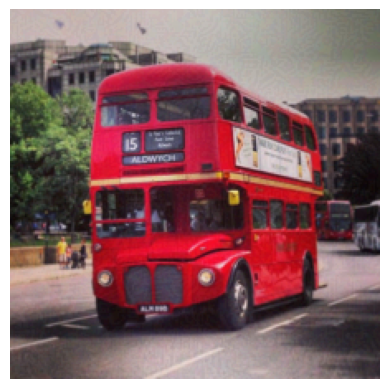

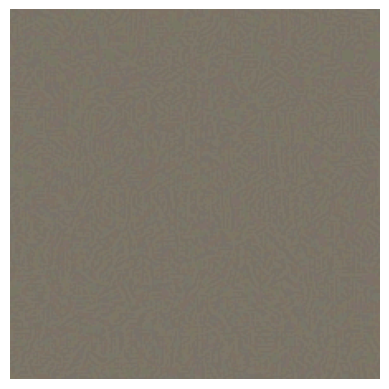

In [13]:
# adv_tensor_img, adv_tensor_noise, _ = fgsm(original_img_tensor, net, pred_idx, device, 0.13)
adv_tensor_img, adv_tensor_noise, _ = fgsm(original_img_tensor, net, top_pred_id, device, 0.05)

print("adv image")
plot_alexnet_image(adv_tensor_img)
plot_alexnet_image(adv_tensor_noise+0.0)

Now we can pass the adversarial image that we just generated to the model and see if it succeeds to mislead the model

In [14]:
confidences, cat_ids = predict_image_top_categories(adv_tensor_img, net, synset_words, device, num_top_cat=5)

for conf, cat_id in zip(confidences, cat_ids):
    print(f'Confidence {conf:.2%}\t{cat_id}\t{synset_words[cat_id]}')

Confidence 87.06%	867	trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
Confidence 3.21%	864	tow truck, tow car, wrecker
Confidence 2.34%	595	harvester, reaper
Confidence 2.14%	569	garbage truck, dustcart
Confidence 1.08%	555	fire engine, fire truck


## References


* [Adversarial Example Generation in PyTorch](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
* [Generating Adversarial Examples using PyTorch](https://savan77.github.io/blog/imagenet_adv_examples.html)
* [Adversarial attacks with FGSM (Fast Gradient Sign Method)](https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/)
* [Targeted adversarial attacks with Keras and TensorFlow](https://www.pyimagesearch.com/2020/10/26/targeted-adversarial-attacks-with-keras-and-tensorflow/)
* [Perhaps the Simplest Introduction of Adversarial Examples Ever](https://towardsdatascience.com/perhaps-the-simplest-introduction-of-adversarial-examples-ever-c0839a759b8d)
* [Targeted adversarial attacks with Keras and TensorFlow](https://www.pyimagesearch.com/2020/10/26/targeted-adversarial-attacks-with-keras-and-tensorflow/)

### Bibliography

```{bibliography}
:filter: docname in docnames
```
